### Imports

In [34]:
import operator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import rfpimp
from datetime import datetime
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import feature_selection
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, Imputer, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, fbeta_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
%matplotlib inline
sns.set()

# %load_ext autoreload
# %autoreload 2

### Aux Functions

In [2]:
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]
    
    
def univariate_auc(dataset, variable_name):
    le = LabelEncoder()
    sorted_dataset = dataset[[variable_name, "TYPE"]].sort_values(by=variable_name).dropna()
    fpr, tpr, _ = roc_curve(le.fit_transform(sorted_dataset.TYPE), sorted_dataset[[variable_name]])
    return auc(fpr, tpr)

def balanced_accuracy(dataset, variable_name):
    tp = dataset[(dataset.TYPE == "Pathogenic") & dataset[variable_name]].shape[0]
    p = dataset[dataset.TYPE == "Pathogenic"].shape[0]
    tn = dataset[(dataset.TYPE == "Benign") & (~dataset[variable_name])].shape[0]
    n = dataset[dataset.TYPE == "Benign"].shape[0]
    return (tp/p + tn/n) / 2

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))


In [3]:
start = timer()
timer(start)


 Time taken: 0 hours 0 minutes and 0.0 seconds.


### Analysis

In [4]:
# varq = pd.read_csv("../data/processed/properties-varq.tab.gz", sep="\t", index_col="MUTANT")
# varq = pd.read_csv("../data/processed/humsavar_varq_gt.csv.gz", sep=",", index_col="MUTANT").drop("dbSNP", 1)
varq = pd.read_csv("../data/processed/varq/varq_clean.csv.gz", index_col="MUTANT")
varq = varq[varq.TYPE != "Unclassified"].drop(["ACTIVE_SITE"], 1)
# varq['random'] = np.random.random(size=len(varq))


In [5]:
varq.to_csv("../data/processed/varq/dataset.csv.gz", compression="gzip", index=True, index_label="MUTANT")

In [6]:
varq.columns

Index(['SASA', 'SASA_PERCENTAGE', 'BFACTOR', 'SWITCHBILITY', 'AGGREGABILITY',
       'CONSERVATION', '3DID', 'PDB', 'VARIATION_ENERGY', 'TYPE'],
      dtype='object')

In [7]:
varq.index.unique().shape

(7418,)

In [8]:
varq.TYPE.value_counts()

Pathogenic    5377
Benign        2041
Name: TYPE, dtype: int64

### Machine Learning

In [9]:
# feature_union = 
cat_vars = ["PDB", "3DID"]
cont_vars = varq.columns[~varq.columns.isin(cat_vars + ["TYPE"])].tolist()



impute = ('union', 
          FeatureUnion(
              transformer_list=[
                  ('continuous', Pipeline([
                      ('selector', ItemSelector(key=cont_vars)),
                      ('imputer', Imputer(missing_values="NaN", strategy="median"))
                  ])),
                  ('categorical', Pipeline([
                      ('selector', ItemSelector(key=cat_vars)),
                      ('imputer', Imputer(missing_values="NaN", strategy="most_frequent"))
                      
                  ]))
              ]))
                  
    
scale = ('scaler', RobustScaler())

model_dict = {
    'lr':{'pipe':[impute, scale, ('lr', LogisticRegression())],
        'params':[{'lr__C' : [.001, .01, .1, 1, 10, 100, 1000], 'lr__class_weight':[None, 'balanced']}],
        'name':'LogisticRegression'
    },
    'rf':{'pipe':[impute, ('rf', RandomForestClassifier(random_state = 100))],
        'params':[{'rf__max_depth':[3,5,7], 'rf__n_estimators':[10,50,100], 'rf__max_features':[4,'sqrt',0.2]}],
        'name':'Random Forest'
    },
    'svc':{'pipe': [impute, scale, ('svc', SVC(kernel='rbf', probability=True))],
           'params':[{'svc__kernel': ['rbf'], 'svc__gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                'svc__C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}]
        
    },
}

In [10]:
for variable in cont_vars:
    print(variable, ":", univariate_auc(varq, variable))

SASA : 0.34141093759980334
SASA_PERCENTAGE : 0.3315827065176701
BFACTOR : 0.45893877338986594
SWITCHBILITY : 0.4988704594020753
AGGREGABILITY : 0.5127936444721555
CONSERVATION : 0.4354685245310245
VARIATION_ENERGY : 0.6836003366726937


In [11]:
for variable in cat_vars:
    print(variable, ":", balanced_accuracy(varq, variable))

PDB : 0.4941370219957124
3DID : 0.519917841948809


In [12]:
le = LabelEncoder()
X = varq[~varq.TYPE.isnull()].drop(['TYPE'], 1)
y = le.fit_transform(varq[~varq.TYPE.isnull()].TYPE)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)


#### Random Forest

In [13]:
folds = 3
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1001)
algorithm = 'rf'
model = Pipeline(model_dict[algorithm]['pipe'])
param_list = [model_dict[algorithm]['params']][0]
gs = GridSearchCV(model, param_list, cv=skf.split(X_train, y_train), n_jobs=2, 
                  scoring='roc_auc', verbose=1, refit=True)

In [14]:
start = timer()
gs.fit(X_train, y_train)
timer(start)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=2)]: Done  81 out of  81 | elapsed:    7.9s finished



 Time taken: 0 hours 0 minutes and 8.67 seconds.


In [15]:
gs.best_params_

{'rf__max_depth': 7, 'rf__max_features': 4, 'rf__n_estimators': 100}

In [16]:
rf = gs.best_estimator_

In [17]:
pd.Series(y_test).value_counts()

1    1774
0     674
dtype: int64

In [18]:
start = timer()
y_pred = rf.predict(X_test)
timer(start)


 Time taken: 0 hours 0 minutes and 0.04 seconds.


In [19]:
f1_score(y_test, y_pred)

0.8391715673740732

In [20]:
precision_score(y_test, rf.predict(X_test), 2)

0.7678989237248479

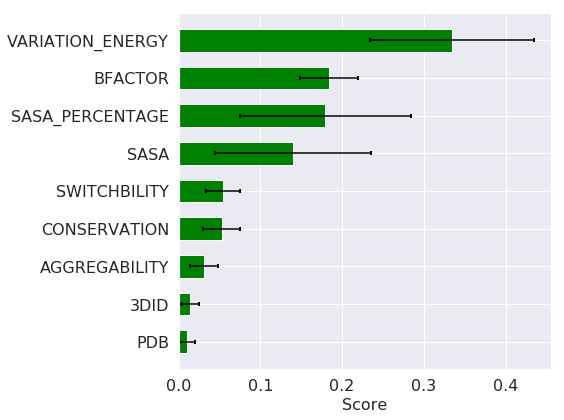

In [44]:
cols = (cont_vars + cat_vars)
ranking_size = 10
forest = rf.steps[1][1]

importances = [(cols[e], x) for e, x in enumerate(forest.feature_importances_)]
importances.sort(key=operator.itemgetter(1), reverse=True)
indices = np.argsort(forest.feature_importances_)[:ranking_size]
importances = importances[:ranking_size][::-1]
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
plt.figure(figsize=(8,6))
plt.barh(np.arange(len(importances)), [y for x, y in importances], 0.6, color="green", align="center", 
         xerr=std[indices], ecolor="black", error_kw={"capthick":2, "capsize":2})
plt.yticks(range(len(importances)), [x for x, y in importances], rotation='horizontal', fontsize=16)
plt.xlabel("Score",fontsize=16)
plt.xticks(fontsize=16)
plt.tight_layout()

# plt.savefig("/home/marlan/Desktop/importances_varq.pdf", bbox_inches='tight', pad_inches=0.1)



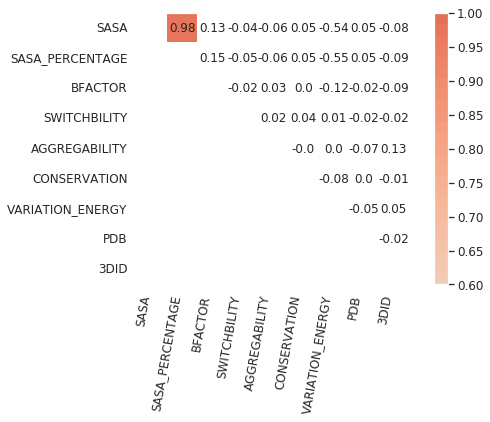

In [43]:
scaled_df = pd.DataFrame(scale[1].fit_transform(impute[1].fit_transform(X)), columns=(cont_vars+cat_vars))
rfpimp.plot_corr_heatmap(scaled_df, figsize=(9,5), label_fontsize=12, value_fontsize=12, save="/home/marlan/Desktop/varq_corrplot.pdf")

In [24]:
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

In [25]:
roc_auc

0.7419857051575846

In [26]:
roc_curve = pd.concat([pd.Series(fpr,name="fpr"), pd.Series(tpr, name="tpr")], axis=1)
roc_curve.to_csv("../results/varq/auc_rf.csv", index=False)

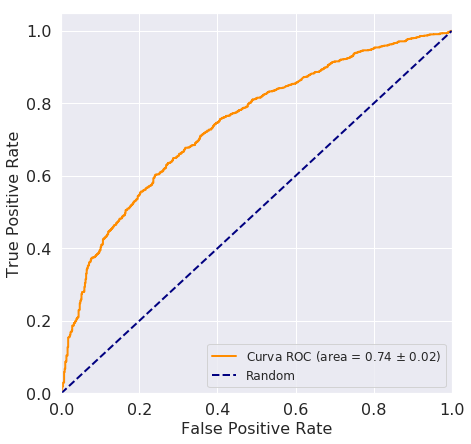

In [37]:
plt.figure(figsize=(7,7))

lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Curva ROC (area = %0.2f $\pm$ 0.02)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.title('AUC Curve')
plt.legend(loc="lower right", prop={'size': 12})

# plt.savefig("/home/marlan/Desktop/auc_varq.pdf", bbox_inches='tight', pad_inches=0.1)

In [29]:
### Confidence Interval for AUC

import numpy as np
from scipy.stats import sem
from sklearn.metrics import roc_auc_score

y_pred = rf.predict_proba(X_test)[:, 1]
y_true = y_test

print("Original ROC area: {:0.3f}".format(roc_auc_score(y_true, y_pred)))

n_bootstraps = 10000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

Original ROC area: 0.742
Bootstrap #1 ROC area: 0.745
Bootstrap #2 ROC area: 0.734
Bootstrap #3 ROC area: 0.735
Bootstrap #4 ROC area: 0.747
Bootstrap #5 ROC area: 0.746
Bootstrap #6 ROC area: 0.736
Bootstrap #7 ROC area: 0.745
Bootstrap #8 ROC area: 0.743
Bootstrap #9 ROC area: 0.732
Bootstrap #10 ROC area: 0.732
Bootstrap #11 ROC area: 0.768
Bootstrap #12 ROC area: 0.735
Bootstrap #13 ROC area: 0.739
Bootstrap #14 ROC area: 0.745
Bootstrap #15 ROC area: 0.729
Bootstrap #16 ROC area: 0.751
Bootstrap #17 ROC area: 0.754
Bootstrap #18 ROC area: 0.752
Bootstrap #19 ROC area: 0.736
Bootstrap #20 ROC area: 0.731
Bootstrap #21 ROC area: 0.744
Bootstrap #22 ROC area: 0.738
Bootstrap #23 ROC area: 0.736
Bootstrap #24 ROC area: 0.763
Bootstrap #25 ROC area: 0.737
Bootstrap #26 ROC area: 0.749
Bootstrap #27 ROC area: 0.746
Bootstrap #28 ROC area: 0.759
Bootstrap #29 ROC area: 0.730
Bootstrap #30 ROC area: 0.740
Bootstrap #31 ROC area: 0.756
Bootstrap #32 ROC area: 0.739
Bootstrap #33 ROC area: 

/home/marlan/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:19: DeprecationWarning: This function is deprecated. Please call randint(0, 2447 + 1) instead


Bootstrap #186 ROC area: 0.730
Bootstrap #187 ROC area: 0.751
Bootstrap #188 ROC area: 0.740
Bootstrap #189 ROC area: 0.741
Bootstrap #190 ROC area: 0.743
Bootstrap #191 ROC area: 0.760
Bootstrap #192 ROC area: 0.745
Bootstrap #193 ROC area: 0.731
Bootstrap #194 ROC area: 0.752
Bootstrap #195 ROC area: 0.736
Bootstrap #196 ROC area: 0.757
Bootstrap #197 ROC area: 0.765
Bootstrap #198 ROC area: 0.748
Bootstrap #199 ROC area: 0.725
Bootstrap #200 ROC area: 0.760
Bootstrap #201 ROC area: 0.743
Bootstrap #202 ROC area: 0.717
Bootstrap #203 ROC area: 0.748
Bootstrap #204 ROC area: 0.736
Bootstrap #205 ROC area: 0.745
Bootstrap #206 ROC area: 0.740
Bootstrap #207 ROC area: 0.752
Bootstrap #208 ROC area: 0.759
Bootstrap #209 ROC area: 0.756
Bootstrap #210 ROC area: 0.731
Bootstrap #211 ROC area: 0.753
Bootstrap #212 ROC area: 0.735
Bootstrap #213 ROC area: 0.744
Bootstrap #214 ROC area: 0.755
Bootstrap #215 ROC area: 0.724
Bootstrap #216 ROC area: 0.755
Bootstrap #217 ROC area: 0.743
Bootstra

Bootstrap #534 ROC area: 0.737
Bootstrap #535 ROC area: 0.749
Bootstrap #536 ROC area: 0.743
Bootstrap #537 ROC area: 0.737
Bootstrap #538 ROC area: 0.746
Bootstrap #539 ROC area: 0.748
Bootstrap #540 ROC area: 0.746
Bootstrap #541 ROC area: 0.762
Bootstrap #542 ROC area: 0.753
Bootstrap #543 ROC area: 0.723
Bootstrap #544 ROC area: 0.732
Bootstrap #545 ROC area: 0.745
Bootstrap #546 ROC area: 0.746
Bootstrap #547 ROC area: 0.745
Bootstrap #548 ROC area: 0.738
Bootstrap #549 ROC area: 0.735
Bootstrap #550 ROC area: 0.722
Bootstrap #551 ROC area: 0.735
Bootstrap #552 ROC area: 0.723
Bootstrap #553 ROC area: 0.748
Bootstrap #554 ROC area: 0.748
Bootstrap #555 ROC area: 0.755
Bootstrap #556 ROC area: 0.734
Bootstrap #557 ROC area: 0.749
Bootstrap #558 ROC area: 0.742
Bootstrap #559 ROC area: 0.773
Bootstrap #560 ROC area: 0.735
Bootstrap #561 ROC area: 0.759
Bootstrap #562 ROC area: 0.736
Bootstrap #563 ROC area: 0.765
Bootstrap #564 ROC area: 0.729
Bootstrap #565 ROC area: 0.727
Bootstra

Bootstrap #889 ROC area: 0.731
Bootstrap #890 ROC area: 0.730
Bootstrap #891 ROC area: 0.752
Bootstrap #892 ROC area: 0.741
Bootstrap #893 ROC area: 0.728
Bootstrap #894 ROC area: 0.742
Bootstrap #895 ROC area: 0.745
Bootstrap #896 ROC area: 0.728
Bootstrap #897 ROC area: 0.724
Bootstrap #898 ROC area: 0.740
Bootstrap #899 ROC area: 0.744
Bootstrap #900 ROC area: 0.747
Bootstrap #901 ROC area: 0.743
Bootstrap #902 ROC area: 0.736
Bootstrap #903 ROC area: 0.733
Bootstrap #904 ROC area: 0.727
Bootstrap #905 ROC area: 0.744
Bootstrap #906 ROC area: 0.746
Bootstrap #907 ROC area: 0.740
Bootstrap #908 ROC area: 0.733
Bootstrap #909 ROC area: 0.750
Bootstrap #910 ROC area: 0.754
Bootstrap #911 ROC area: 0.747
Bootstrap #912 ROC area: 0.735
Bootstrap #913 ROC area: 0.736
Bootstrap #914 ROC area: 0.722
Bootstrap #915 ROC area: 0.737
Bootstrap #916 ROC area: 0.753
Bootstrap #917 ROC area: 0.764
Bootstrap #918 ROC area: 0.740
Bootstrap #919 ROC area: 0.752
Bootstrap #920 ROC area: 0.736
Bootstra

Bootstrap #1230 ROC area: 0.731
Bootstrap #1231 ROC area: 0.756
Bootstrap #1232 ROC area: 0.761
Bootstrap #1233 ROC area: 0.724
Bootstrap #1234 ROC area: 0.743
Bootstrap #1235 ROC area: 0.755
Bootstrap #1236 ROC area: 0.739
Bootstrap #1237 ROC area: 0.730
Bootstrap #1238 ROC area: 0.749
Bootstrap #1239 ROC area: 0.750
Bootstrap #1240 ROC area: 0.740
Bootstrap #1241 ROC area: 0.739
Bootstrap #1242 ROC area: 0.731
Bootstrap #1243 ROC area: 0.728
Bootstrap #1244 ROC area: 0.765
Bootstrap #1245 ROC area: 0.736
Bootstrap #1246 ROC area: 0.725
Bootstrap #1247 ROC area: 0.728
Bootstrap #1248 ROC area: 0.719
Bootstrap #1249 ROC area: 0.741
Bootstrap #1250 ROC area: 0.751
Bootstrap #1251 ROC area: 0.733
Bootstrap #1252 ROC area: 0.754
Bootstrap #1253 ROC area: 0.748
Bootstrap #1254 ROC area: 0.744
Bootstrap #1255 ROC area: 0.739
Bootstrap #1256 ROC area: 0.747
Bootstrap #1257 ROC area: 0.746
Bootstrap #1258 ROC area: 0.753
Bootstrap #1259 ROC area: 0.733
Bootstrap #1260 ROC area: 0.732
Bootstra

Bootstrap #1487 ROC area: 0.737
Bootstrap #1488 ROC area: 0.745
Bootstrap #1489 ROC area: 0.746
Bootstrap #1490 ROC area: 0.740
Bootstrap #1491 ROC area: 0.738
Bootstrap #1492 ROC area: 0.756
Bootstrap #1493 ROC area: 0.744
Bootstrap #1494 ROC area: 0.736
Bootstrap #1495 ROC area: 0.739
Bootstrap #1496 ROC area: 0.740
Bootstrap #1497 ROC area: 0.738
Bootstrap #1498 ROC area: 0.744
Bootstrap #1499 ROC area: 0.745
Bootstrap #1500 ROC area: 0.729
Bootstrap #1501 ROC area: 0.747
Bootstrap #1502 ROC area: 0.740
Bootstrap #1503 ROC area: 0.747
Bootstrap #1504 ROC area: 0.755
Bootstrap #1505 ROC area: 0.744
Bootstrap #1506 ROC area: 0.735
Bootstrap #1507 ROC area: 0.739
Bootstrap #1508 ROC area: 0.738
Bootstrap #1509 ROC area: 0.737
Bootstrap #1510 ROC area: 0.730
Bootstrap #1511 ROC area: 0.731
Bootstrap #1512 ROC area: 0.751
Bootstrap #1513 ROC area: 0.764
Bootstrap #1514 ROC area: 0.745
Bootstrap #1515 ROC area: 0.737
Bootstrap #1516 ROC area: 0.751
Bootstrap #1517 ROC area: 0.742
Bootstra

Bootstrap #1870 ROC area: 0.717
Bootstrap #1871 ROC area: 0.751
Bootstrap #1872 ROC area: 0.762
Bootstrap #1873 ROC area: 0.729
Bootstrap #1874 ROC area: 0.743
Bootstrap #1875 ROC area: 0.744
Bootstrap #1876 ROC area: 0.748
Bootstrap #1877 ROC area: 0.749
Bootstrap #1878 ROC area: 0.740
Bootstrap #1879 ROC area: 0.732
Bootstrap #1880 ROC area: 0.747
Bootstrap #1881 ROC area: 0.747
Bootstrap #1882 ROC area: 0.750
Bootstrap #1883 ROC area: 0.742
Bootstrap #1884 ROC area: 0.726
Bootstrap #1885 ROC area: 0.729
Bootstrap #1886 ROC area: 0.716
Bootstrap #1887 ROC area: 0.746
Bootstrap #1888 ROC area: 0.724
Bootstrap #1889 ROC area: 0.741
Bootstrap #1890 ROC area: 0.759
Bootstrap #1891 ROC area: 0.721
Bootstrap #1892 ROC area: 0.762
Bootstrap #1893 ROC area: 0.754
Bootstrap #1894 ROC area: 0.736
Bootstrap #1895 ROC area: 0.732
Bootstrap #1896 ROC area: 0.752
Bootstrap #1897 ROC area: 0.740
Bootstrap #1898 ROC area: 0.758
Bootstrap #1899 ROC area: 0.739
Bootstrap #1900 ROC area: 0.736
Bootstra

Bootstrap #2246 ROC area: 0.725
Bootstrap #2247 ROC area: 0.747
Bootstrap #2248 ROC area: 0.748
Bootstrap #2249 ROC area: 0.734
Bootstrap #2250 ROC area: 0.736
Bootstrap #2251 ROC area: 0.721
Bootstrap #2252 ROC area: 0.730
Bootstrap #2253 ROC area: 0.737
Bootstrap #2254 ROC area: 0.746
Bootstrap #2255 ROC area: 0.742
Bootstrap #2256 ROC area: 0.724
Bootstrap #2257 ROC area: 0.752
Bootstrap #2258 ROC area: 0.729
Bootstrap #2259 ROC area: 0.758
Bootstrap #2260 ROC area: 0.751
Bootstrap #2261 ROC area: 0.747
Bootstrap #2262 ROC area: 0.756
Bootstrap #2263 ROC area: 0.739
Bootstrap #2264 ROC area: 0.731
Bootstrap #2265 ROC area: 0.743
Bootstrap #2266 ROC area: 0.732
Bootstrap #2267 ROC area: 0.736
Bootstrap #2268 ROC area: 0.745
Bootstrap #2269 ROC area: 0.747
Bootstrap #2270 ROC area: 0.740
Bootstrap #2271 ROC area: 0.740
Bootstrap #2272 ROC area: 0.740
Bootstrap #2273 ROC area: 0.752
Bootstrap #2274 ROC area: 0.751
Bootstrap #2275 ROC area: 0.745
Bootstrap #2276 ROC area: 0.745
Bootstra

Bootstrap #2614 ROC area: 0.737
Bootstrap #2615 ROC area: 0.747
Bootstrap #2616 ROC area: 0.762
Bootstrap #2617 ROC area: 0.757
Bootstrap #2618 ROC area: 0.762
Bootstrap #2619 ROC area: 0.746
Bootstrap #2620 ROC area: 0.746
Bootstrap #2621 ROC area: 0.733
Bootstrap #2622 ROC area: 0.729
Bootstrap #2623 ROC area: 0.759
Bootstrap #2624 ROC area: 0.747
Bootstrap #2625 ROC area: 0.732
Bootstrap #2626 ROC area: 0.745
Bootstrap #2627 ROC area: 0.746
Bootstrap #2628 ROC area: 0.743
Bootstrap #2629 ROC area: 0.706
Bootstrap #2630 ROC area: 0.730
Bootstrap #2631 ROC area: 0.752
Bootstrap #2632 ROC area: 0.737
Bootstrap #2633 ROC area: 0.740
Bootstrap #2634 ROC area: 0.747
Bootstrap #2635 ROC area: 0.729
Bootstrap #2636 ROC area: 0.750
Bootstrap #2637 ROC area: 0.750
Bootstrap #2638 ROC area: 0.746
Bootstrap #2639 ROC area: 0.734
Bootstrap #2640 ROC area: 0.752
Bootstrap #2641 ROC area: 0.723
Bootstrap #2642 ROC area: 0.738
Bootstrap #2643 ROC area: 0.746
Bootstrap #2644 ROC area: 0.742
Bootstra

Bootstrap #2946 ROC area: 0.729
Bootstrap #2947 ROC area: 0.755
Bootstrap #2948 ROC area: 0.747
Bootstrap #2949 ROC area: 0.734
Bootstrap #2950 ROC area: 0.738
Bootstrap #2951 ROC area: 0.734
Bootstrap #2952 ROC area: 0.741
Bootstrap #2953 ROC area: 0.733
Bootstrap #2954 ROC area: 0.740
Bootstrap #2955 ROC area: 0.753
Bootstrap #2956 ROC area: 0.752
Bootstrap #2957 ROC area: 0.752
Bootstrap #2958 ROC area: 0.733
Bootstrap #2959 ROC area: 0.737
Bootstrap #2960 ROC area: 0.748
Bootstrap #2961 ROC area: 0.731
Bootstrap #2962 ROC area: 0.740
Bootstrap #2963 ROC area: 0.756
Bootstrap #2964 ROC area: 0.758
Bootstrap #2965 ROC area: 0.742
Bootstrap #2966 ROC area: 0.743
Bootstrap #2967 ROC area: 0.751
Bootstrap #2968 ROC area: 0.734
Bootstrap #2969 ROC area: 0.741
Bootstrap #2970 ROC area: 0.753
Bootstrap #2971 ROC area: 0.718
Bootstrap #2972 ROC area: 0.742
Bootstrap #2973 ROC area: 0.742
Bootstrap #2974 ROC area: 0.738
Bootstrap #2975 ROC area: 0.745
Bootstrap #2976 ROC area: 0.745
Bootstra

Bootstrap #3293 ROC area: 0.752
Bootstrap #3294 ROC area: 0.736
Bootstrap #3295 ROC area: 0.744
Bootstrap #3296 ROC area: 0.735
Bootstrap #3297 ROC area: 0.758
Bootstrap #3298 ROC area: 0.734
Bootstrap #3299 ROC area: 0.741
Bootstrap #3300 ROC area: 0.747
Bootstrap #3301 ROC area: 0.762
Bootstrap #3302 ROC area: 0.742
Bootstrap #3303 ROC area: 0.743
Bootstrap #3304 ROC area: 0.744
Bootstrap #3305 ROC area: 0.743
Bootstrap #3306 ROC area: 0.743
Bootstrap #3307 ROC area: 0.734
Bootstrap #3308 ROC area: 0.732
Bootstrap #3309 ROC area: 0.724
Bootstrap #3310 ROC area: 0.724
Bootstrap #3311 ROC area: 0.743
Bootstrap #3312 ROC area: 0.741
Bootstrap #3313 ROC area: 0.739
Bootstrap #3314 ROC area: 0.747
Bootstrap #3315 ROC area: 0.742
Bootstrap #3316 ROC area: 0.756
Bootstrap #3317 ROC area: 0.761
Bootstrap #3318 ROC area: 0.751
Bootstrap #3319 ROC area: 0.741
Bootstrap #3320 ROC area: 0.754
Bootstrap #3321 ROC area: 0.726
Bootstrap #3322 ROC area: 0.749
Bootstrap #3323 ROC area: 0.740
Bootstra

Bootstrap #3650 ROC area: 0.745
Bootstrap #3651 ROC area: 0.752
Bootstrap #3652 ROC area: 0.736
Bootstrap #3653 ROC area: 0.741
Bootstrap #3654 ROC area: 0.755
Bootstrap #3655 ROC area: 0.747
Bootstrap #3656 ROC area: 0.735
Bootstrap #3657 ROC area: 0.737
Bootstrap #3658 ROC area: 0.731
Bootstrap #3659 ROC area: 0.728
Bootstrap #3660 ROC area: 0.745
Bootstrap #3661 ROC area: 0.753
Bootstrap #3662 ROC area: 0.744
Bootstrap #3663 ROC area: 0.751
Bootstrap #3664 ROC area: 0.737
Bootstrap #3665 ROC area: 0.739
Bootstrap #3666 ROC area: 0.738
Bootstrap #3667 ROC area: 0.747
Bootstrap #3668 ROC area: 0.745
Bootstrap #3669 ROC area: 0.737
Bootstrap #3670 ROC area: 0.749
Bootstrap #3671 ROC area: 0.736
Bootstrap #3672 ROC area: 0.734
Bootstrap #3673 ROC area: 0.750
Bootstrap #3674 ROC area: 0.747
Bootstrap #3675 ROC area: 0.746
Bootstrap #3676 ROC area: 0.747
Bootstrap #3677 ROC area: 0.760
Bootstrap #3678 ROC area: 0.741
Bootstrap #3679 ROC area: 0.757
Bootstrap #3680 ROC area: 0.740
Bootstra

Bootstrap #3975 ROC area: 0.750
Bootstrap #3976 ROC area: 0.743
Bootstrap #3977 ROC area: 0.729
Bootstrap #3978 ROC area: 0.755
Bootstrap #3979 ROC area: 0.772
Bootstrap #3980 ROC area: 0.742
Bootstrap #3981 ROC area: 0.731
Bootstrap #3982 ROC area: 0.727
Bootstrap #3983 ROC area: 0.765
Bootstrap #3984 ROC area: 0.725
Bootstrap #3985 ROC area: 0.747
Bootstrap #3986 ROC area: 0.745
Bootstrap #3987 ROC area: 0.741
Bootstrap #3988 ROC area: 0.742
Bootstrap #3989 ROC area: 0.737
Bootstrap #3990 ROC area: 0.740
Bootstrap #3991 ROC area: 0.756
Bootstrap #3992 ROC area: 0.727
Bootstrap #3993 ROC area: 0.747
Bootstrap #3994 ROC area: 0.763
Bootstrap #3995 ROC area: 0.755
Bootstrap #3996 ROC area: 0.741
Bootstrap #3997 ROC area: 0.748
Bootstrap #3998 ROC area: 0.717
Bootstrap #3999 ROC area: 0.741
Bootstrap #4000 ROC area: 0.762
Bootstrap #4001 ROC area: 0.743
Bootstrap #4002 ROC area: 0.718
Bootstrap #4003 ROC area: 0.750
Bootstrap #4004 ROC area: 0.744
Bootstrap #4005 ROC area: 0.743
Bootstra

Bootstrap #4336 ROC area: 0.737
Bootstrap #4337 ROC area: 0.738
Bootstrap #4338 ROC area: 0.752
Bootstrap #4339 ROC area: 0.737
Bootstrap #4340 ROC area: 0.737
Bootstrap #4341 ROC area: 0.740
Bootstrap #4342 ROC area: 0.739
Bootstrap #4343 ROC area: 0.731
Bootstrap #4344 ROC area: 0.732
Bootstrap #4345 ROC area: 0.741
Bootstrap #4346 ROC area: 0.731
Bootstrap #4347 ROC area: 0.752
Bootstrap #4348 ROC area: 0.742
Bootstrap #4349 ROC area: 0.739
Bootstrap #4350 ROC area: 0.745
Bootstrap #4351 ROC area: 0.763
Bootstrap #4352 ROC area: 0.739
Bootstrap #4353 ROC area: 0.758
Bootstrap #4354 ROC area: 0.745
Bootstrap #4355 ROC area: 0.754
Bootstrap #4356 ROC area: 0.759
Bootstrap #4357 ROC area: 0.747
Bootstrap #4358 ROC area: 0.734
Bootstrap #4359 ROC area: 0.757
Bootstrap #4360 ROC area: 0.728
Bootstrap #4361 ROC area: 0.732
Bootstrap #4362 ROC area: 0.734
Bootstrap #4363 ROC area: 0.717
Bootstrap #4364 ROC area: 0.732
Bootstrap #4365 ROC area: 0.749
Bootstrap #4366 ROC area: 0.731
Bootstra

Bootstrap #4681 ROC area: 0.748
Bootstrap #4682 ROC area: 0.743
Bootstrap #4683 ROC area: 0.741
Bootstrap #4684 ROC area: 0.744
Bootstrap #4685 ROC area: 0.747
Bootstrap #4686 ROC area: 0.753
Bootstrap #4687 ROC area: 0.756
Bootstrap #4688 ROC area: 0.738
Bootstrap #4689 ROC area: 0.738
Bootstrap #4690 ROC area: 0.753
Bootstrap #4691 ROC area: 0.743
Bootstrap #4692 ROC area: 0.735
Bootstrap #4693 ROC area: 0.749
Bootstrap #4694 ROC area: 0.754
Bootstrap #4695 ROC area: 0.743
Bootstrap #4696 ROC area: 0.735
Bootstrap #4697 ROC area: 0.728
Bootstrap #4698 ROC area: 0.739
Bootstrap #4699 ROC area: 0.751
Bootstrap #4700 ROC area: 0.734
Bootstrap #4701 ROC area: 0.741
Bootstrap #4702 ROC area: 0.744
Bootstrap #4703 ROC area: 0.737
Bootstrap #4704 ROC area: 0.743
Bootstrap #4705 ROC area: 0.755
Bootstrap #4706 ROC area: 0.738
Bootstrap #4707 ROC area: 0.718
Bootstrap #4708 ROC area: 0.757
Bootstrap #4709 ROC area: 0.737
Bootstrap #4710 ROC area: 0.740
Bootstrap #4711 ROC area: 0.744
Bootstra

Bootstrap #5001 ROC area: 0.728
Bootstrap #5002 ROC area: 0.738
Bootstrap #5003 ROC area: 0.737
Bootstrap #5004 ROC area: 0.714
Bootstrap #5005 ROC area: 0.736
Bootstrap #5006 ROC area: 0.738
Bootstrap #5007 ROC area: 0.724
Bootstrap #5008 ROC area: 0.737
Bootstrap #5009 ROC area: 0.740
Bootstrap #5010 ROC area: 0.726
Bootstrap #5011 ROC area: 0.741
Bootstrap #5012 ROC area: 0.739
Bootstrap #5013 ROC area: 0.746
Bootstrap #5014 ROC area: 0.739
Bootstrap #5015 ROC area: 0.751
Bootstrap #5016 ROC area: 0.743
Bootstrap #5017 ROC area: 0.749
Bootstrap #5018 ROC area: 0.745
Bootstrap #5019 ROC area: 0.745
Bootstrap #5020 ROC area: 0.745
Bootstrap #5021 ROC area: 0.752
Bootstrap #5022 ROC area: 0.730
Bootstrap #5023 ROC area: 0.737
Bootstrap #5024 ROC area: 0.749
Bootstrap #5025 ROC area: 0.734
Bootstrap #5026 ROC area: 0.756
Bootstrap #5027 ROC area: 0.736
Bootstrap #5028 ROC area: 0.734
Bootstrap #5029 ROC area: 0.750
Bootstrap #5030 ROC area: 0.748
Bootstrap #5031 ROC area: 0.747
Bootstra

Bootstrap #5334 ROC area: 0.756
Bootstrap #5335 ROC area: 0.746
Bootstrap #5336 ROC area: 0.738
Bootstrap #5337 ROC area: 0.727
Bootstrap #5338 ROC area: 0.745
Bootstrap #5339 ROC area: 0.718
Bootstrap #5340 ROC area: 0.728
Bootstrap #5341 ROC area: 0.744
Bootstrap #5342 ROC area: 0.738
Bootstrap #5343 ROC area: 0.732
Bootstrap #5344 ROC area: 0.756
Bootstrap #5345 ROC area: 0.750
Bootstrap #5346 ROC area: 0.731
Bootstrap #5347 ROC area: 0.736
Bootstrap #5348 ROC area: 0.760
Bootstrap #5349 ROC area: 0.728
Bootstrap #5350 ROC area: 0.737
Bootstrap #5351 ROC area: 0.748
Bootstrap #5352 ROC area: 0.744
Bootstrap #5353 ROC area: 0.738
Bootstrap #5354 ROC area: 0.731
Bootstrap #5355 ROC area: 0.746
Bootstrap #5356 ROC area: 0.740
Bootstrap #5357 ROC area: 0.753
Bootstrap #5358 ROC area: 0.734
Bootstrap #5359 ROC area: 0.765
Bootstrap #5360 ROC area: 0.724
Bootstrap #5361 ROC area: 0.743
Bootstrap #5362 ROC area: 0.745
Bootstrap #5363 ROC area: 0.739
Bootstrap #5364 ROC area: 0.757
Bootstra

Bootstrap #5711 ROC area: 0.739
Bootstrap #5712 ROC area: 0.745
Bootstrap #5713 ROC area: 0.734
Bootstrap #5714 ROC area: 0.738
Bootstrap #5715 ROC area: 0.735
Bootstrap #5716 ROC area: 0.745
Bootstrap #5717 ROC area: 0.738
Bootstrap #5718 ROC area: 0.765
Bootstrap #5719 ROC area: 0.744
Bootstrap #5720 ROC area: 0.735
Bootstrap #5721 ROC area: 0.740
Bootstrap #5722 ROC area: 0.742
Bootstrap #5723 ROC area: 0.719
Bootstrap #5724 ROC area: 0.749
Bootstrap #5725 ROC area: 0.733
Bootstrap #5726 ROC area: 0.729
Bootstrap #5727 ROC area: 0.749
Bootstrap #5728 ROC area: 0.729
Bootstrap #5729 ROC area: 0.744
Bootstrap #5730 ROC area: 0.737
Bootstrap #5731 ROC area: 0.740
Bootstrap #5732 ROC area: 0.720
Bootstrap #5733 ROC area: 0.739
Bootstrap #5734 ROC area: 0.740
Bootstrap #5735 ROC area: 0.739
Bootstrap #5736 ROC area: 0.735
Bootstrap #5737 ROC area: 0.735
Bootstrap #5738 ROC area: 0.737
Bootstrap #5739 ROC area: 0.739
Bootstrap #5740 ROC area: 0.745
Bootstrap #5741 ROC area: 0.767
Bootstra

Bootstrap #5999 ROC area: 0.716
Bootstrap #6000 ROC area: 0.743
Bootstrap #6001 ROC area: 0.737
Bootstrap #6002 ROC area: 0.756
Bootstrap #6003 ROC area: 0.749
Bootstrap #6004 ROC area: 0.737
Bootstrap #6005 ROC area: 0.734
Bootstrap #6006 ROC area: 0.740
Bootstrap #6007 ROC area: 0.737
Bootstrap #6008 ROC area: 0.759
Bootstrap #6009 ROC area: 0.746
Bootstrap #6010 ROC area: 0.735
Bootstrap #6011 ROC area: 0.723
Bootstrap #6012 ROC area: 0.756
Bootstrap #6013 ROC area: 0.741
Bootstrap #6014 ROC area: 0.744
Bootstrap #6015 ROC area: 0.733
Bootstrap #6016 ROC area: 0.753
Bootstrap #6017 ROC area: 0.741
Bootstrap #6018 ROC area: 0.759
Bootstrap #6019 ROC area: 0.744
Bootstrap #6020 ROC area: 0.750
Bootstrap #6021 ROC area: 0.734
Bootstrap #6022 ROC area: 0.739
Bootstrap #6023 ROC area: 0.740
Bootstrap #6024 ROC area: 0.720
Bootstrap #6025 ROC area: 0.740
Bootstrap #6026 ROC area: 0.740
Bootstrap #6027 ROC area: 0.743
Bootstrap #6028 ROC area: 0.723
Bootstrap #6029 ROC area: 0.752
Bootstra

Bootstrap #6281 ROC area: 0.742
Bootstrap #6282 ROC area: 0.751
Bootstrap #6283 ROC area: 0.756
Bootstrap #6284 ROC area: 0.720
Bootstrap #6285 ROC area: 0.748
Bootstrap #6286 ROC area: 0.729
Bootstrap #6287 ROC area: 0.747
Bootstrap #6288 ROC area: 0.737
Bootstrap #6289 ROC area: 0.738
Bootstrap #6290 ROC area: 0.729
Bootstrap #6291 ROC area: 0.740
Bootstrap #6292 ROC area: 0.730
Bootstrap #6293 ROC area: 0.725
Bootstrap #6294 ROC area: 0.728
Bootstrap #6295 ROC area: 0.742
Bootstrap #6296 ROC area: 0.747
Bootstrap #6297 ROC area: 0.736
Bootstrap #6298 ROC area: 0.733
Bootstrap #6299 ROC area: 0.735
Bootstrap #6300 ROC area: 0.717
Bootstrap #6301 ROC area: 0.761
Bootstrap #6302 ROC area: 0.736
Bootstrap #6303 ROC area: 0.745
Bootstrap #6304 ROC area: 0.737
Bootstrap #6305 ROC area: 0.763
Bootstrap #6306 ROC area: 0.741
Bootstrap #6307 ROC area: 0.744
Bootstrap #6308 ROC area: 0.732
Bootstrap #6309 ROC area: 0.750
Bootstrap #6310 ROC area: 0.730
Bootstrap #6311 ROC area: 0.734
Bootstra

Bootstrap #6612 ROC area: 0.734
Bootstrap #6613 ROC area: 0.756
Bootstrap #6614 ROC area: 0.747
Bootstrap #6615 ROC area: 0.740
Bootstrap #6616 ROC area: 0.739
Bootstrap #6617 ROC area: 0.735
Bootstrap #6618 ROC area: 0.753
Bootstrap #6619 ROC area: 0.752
Bootstrap #6620 ROC area: 0.749
Bootstrap #6621 ROC area: 0.743
Bootstrap #6622 ROC area: 0.749
Bootstrap #6623 ROC area: 0.750
Bootstrap #6624 ROC area: 0.752
Bootstrap #6625 ROC area: 0.737
Bootstrap #6626 ROC area: 0.735
Bootstrap #6627 ROC area: 0.748
Bootstrap #6628 ROC area: 0.746
Bootstrap #6629 ROC area: 0.745
Bootstrap #6630 ROC area: 0.743
Bootstrap #6631 ROC area: 0.725
Bootstrap #6632 ROC area: 0.755
Bootstrap #6633 ROC area: 0.742
Bootstrap #6634 ROC area: 0.755
Bootstrap #6635 ROC area: 0.759
Bootstrap #6636 ROC area: 0.744
Bootstrap #6637 ROC area: 0.744
Bootstrap #6638 ROC area: 0.747
Bootstrap #6639 ROC area: 0.724
Bootstrap #6640 ROC area: 0.751
Bootstrap #6641 ROC area: 0.750
Bootstrap #6642 ROC area: 0.767
Bootstra

Bootstrap #6965 ROC area: 0.733
Bootstrap #6966 ROC area: 0.757
Bootstrap #6967 ROC area: 0.753
Bootstrap #6968 ROC area: 0.732
Bootstrap #6969 ROC area: 0.740
Bootstrap #6970 ROC area: 0.745
Bootstrap #6971 ROC area: 0.734
Bootstrap #6972 ROC area: 0.725
Bootstrap #6973 ROC area: 0.748
Bootstrap #6974 ROC area: 0.747
Bootstrap #6975 ROC area: 0.753
Bootstrap #6976 ROC area: 0.733
Bootstrap #6977 ROC area: 0.727
Bootstrap #6978 ROC area: 0.750
Bootstrap #6979 ROC area: 0.757
Bootstrap #6980 ROC area: 0.739
Bootstrap #6981 ROC area: 0.761
Bootstrap #6982 ROC area: 0.747
Bootstrap #6983 ROC area: 0.740
Bootstrap #6984 ROC area: 0.748
Bootstrap #6985 ROC area: 0.731
Bootstrap #6986 ROC area: 0.748
Bootstrap #6987 ROC area: 0.706
Bootstrap #6988 ROC area: 0.759
Bootstrap #6989 ROC area: 0.735
Bootstrap #6990 ROC area: 0.731
Bootstrap #6991 ROC area: 0.735
Bootstrap #6992 ROC area: 0.735
Bootstrap #6993 ROC area: 0.730
Bootstrap #6994 ROC area: 0.743
Bootstrap #6995 ROC area: 0.737
Bootstra

Bootstrap #7274 ROC area: 0.765
Bootstrap #7275 ROC area: 0.725
Bootstrap #7276 ROC area: 0.755
Bootstrap #7277 ROC area: 0.747
Bootstrap #7278 ROC area: 0.732
Bootstrap #7279 ROC area: 0.747
Bootstrap #7280 ROC area: 0.739
Bootstrap #7281 ROC area: 0.757
Bootstrap #7282 ROC area: 0.729
Bootstrap #7283 ROC area: 0.734
Bootstrap #7284 ROC area: 0.739
Bootstrap #7285 ROC area: 0.745
Bootstrap #7286 ROC area: 0.749
Bootstrap #7287 ROC area: 0.742
Bootstrap #7288 ROC area: 0.751
Bootstrap #7289 ROC area: 0.750
Bootstrap #7290 ROC area: 0.738
Bootstrap #7291 ROC area: 0.745
Bootstrap #7292 ROC area: 0.741
Bootstrap #7293 ROC area: 0.734
Bootstrap #7294 ROC area: 0.724
Bootstrap #7295 ROC area: 0.737
Bootstrap #7296 ROC area: 0.740
Bootstrap #7297 ROC area: 0.759
Bootstrap #7298 ROC area: 0.751
Bootstrap #7299 ROC area: 0.735
Bootstrap #7300 ROC area: 0.738
Bootstrap #7301 ROC area: 0.745
Bootstrap #7302 ROC area: 0.738
Bootstrap #7303 ROC area: 0.747
Bootstrap #7304 ROC area: 0.728
Bootstra

Bootstrap #7662 ROC area: 0.762
Bootstrap #7663 ROC area: 0.735
Bootstrap #7664 ROC area: 0.748
Bootstrap #7665 ROC area: 0.746
Bootstrap #7666 ROC area: 0.715
Bootstrap #7667 ROC area: 0.741
Bootstrap #7668 ROC area: 0.749
Bootstrap #7669 ROC area: 0.754
Bootstrap #7670 ROC area: 0.752
Bootstrap #7671 ROC area: 0.757
Bootstrap #7672 ROC area: 0.735
Bootstrap #7673 ROC area: 0.739
Bootstrap #7674 ROC area: 0.759
Bootstrap #7675 ROC area: 0.737
Bootstrap #7676 ROC area: 0.756
Bootstrap #7677 ROC area: 0.738
Bootstrap #7678 ROC area: 0.748
Bootstrap #7679 ROC area: 0.748
Bootstrap #7680 ROC area: 0.747
Bootstrap #7681 ROC area: 0.749
Bootstrap #7682 ROC area: 0.743
Bootstrap #7683 ROC area: 0.751
Bootstrap #7684 ROC area: 0.728
Bootstrap #7685 ROC area: 0.752
Bootstrap #7686 ROC area: 0.742
Bootstrap #7687 ROC area: 0.754
Bootstrap #7688 ROC area: 0.749
Bootstrap #7689 ROC area: 0.715
Bootstrap #7690 ROC area: 0.738
Bootstrap #7691 ROC area: 0.722
Bootstrap #7692 ROC area: 0.740
Bootstra

Bootstrap #7957 ROC area: 0.761
Bootstrap #7958 ROC area: 0.745
Bootstrap #7959 ROC area: 0.748
Bootstrap #7960 ROC area: 0.759
Bootstrap #7961 ROC area: 0.737
Bootstrap #7962 ROC area: 0.735
Bootstrap #7963 ROC area: 0.757
Bootstrap #7964 ROC area: 0.737
Bootstrap #7965 ROC area: 0.738
Bootstrap #7966 ROC area: 0.748
Bootstrap #7967 ROC area: 0.729
Bootstrap #7968 ROC area: 0.745
Bootstrap #7969 ROC area: 0.748
Bootstrap #7970 ROC area: 0.731
Bootstrap #7971 ROC area: 0.744
Bootstrap #7972 ROC area: 0.749
Bootstrap #7973 ROC area: 0.745
Bootstrap #7974 ROC area: 0.725
Bootstrap #7975 ROC area: 0.742
Bootstrap #7976 ROC area: 0.745
Bootstrap #7977 ROC area: 0.746
Bootstrap #7978 ROC area: 0.730
Bootstrap #7979 ROC area: 0.729
Bootstrap #7980 ROC area: 0.727
Bootstrap #7981 ROC area: 0.728
Bootstrap #7982 ROC area: 0.745
Bootstrap #7983 ROC area: 0.748
Bootstrap #7984 ROC area: 0.753
Bootstrap #7985 ROC area: 0.727
Bootstrap #7986 ROC area: 0.747
Bootstrap #7987 ROC area: 0.757
Bootstra

Bootstrap #8269 ROC area: 0.752
Bootstrap #8270 ROC area: 0.734
Bootstrap #8271 ROC area: 0.736
Bootstrap #8272 ROC area: 0.736
Bootstrap #8273 ROC area: 0.757
Bootstrap #8274 ROC area: 0.734
Bootstrap #8275 ROC area: 0.750
Bootstrap #8276 ROC area: 0.755
Bootstrap #8277 ROC area: 0.761
Bootstrap #8278 ROC area: 0.735
Bootstrap #8279 ROC area: 0.736
Bootstrap #8280 ROC area: 0.761
Bootstrap #8281 ROC area: 0.769
Bootstrap #8282 ROC area: 0.738
Bootstrap #8283 ROC area: 0.726
Bootstrap #8284 ROC area: 0.752
Bootstrap #8285 ROC area: 0.746
Bootstrap #8286 ROC area: 0.741
Bootstrap #8287 ROC area: 0.725
Bootstrap #8288 ROC area: 0.756
Bootstrap #8289 ROC area: 0.749
Bootstrap #8290 ROC area: 0.757
Bootstrap #8291 ROC area: 0.741
Bootstrap #8292 ROC area: 0.726
Bootstrap #8293 ROC area: 0.734
Bootstrap #8294 ROC area: 0.741
Bootstrap #8295 ROC area: 0.737
Bootstrap #8296 ROC area: 0.717
Bootstrap #8297 ROC area: 0.744
Bootstrap #8298 ROC area: 0.746
Bootstrap #8299 ROC area: 0.751
Bootstra

Bootstrap #8598 ROC area: 0.752
Bootstrap #8599 ROC area: 0.744
Bootstrap #8600 ROC area: 0.753
Bootstrap #8601 ROC area: 0.764
Bootstrap #8602 ROC area: 0.741
Bootstrap #8603 ROC area: 0.767
Bootstrap #8604 ROC area: 0.730
Bootstrap #8605 ROC area: 0.736
Bootstrap #8606 ROC area: 0.727
Bootstrap #8607 ROC area: 0.727
Bootstrap #8608 ROC area: 0.742
Bootstrap #8609 ROC area: 0.752
Bootstrap #8610 ROC area: 0.736
Bootstrap #8611 ROC area: 0.745
Bootstrap #8612 ROC area: 0.755
Bootstrap #8613 ROC area: 0.743
Bootstrap #8614 ROC area: 0.764
Bootstrap #8615 ROC area: 0.756
Bootstrap #8616 ROC area: 0.755
Bootstrap #8617 ROC area: 0.737
Bootstrap #8618 ROC area: 0.738
Bootstrap #8619 ROC area: 0.730
Bootstrap #8620 ROC area: 0.732
Bootstrap #8621 ROC area: 0.727
Bootstrap #8622 ROC area: 0.737
Bootstrap #8623 ROC area: 0.744
Bootstrap #8624 ROC area: 0.742
Bootstrap #8625 ROC area: 0.748
Bootstrap #8626 ROC area: 0.749
Bootstrap #8627 ROC area: 0.738
Bootstrap #8628 ROC area: 0.737
Bootstra

Bootstrap #8906 ROC area: 0.730
Bootstrap #8907 ROC area: 0.771
Bootstrap #8908 ROC area: 0.748
Bootstrap #8909 ROC area: 0.747
Bootstrap #8910 ROC area: 0.752
Bootstrap #8911 ROC area: 0.743
Bootstrap #8912 ROC area: 0.756
Bootstrap #8913 ROC area: 0.736
Bootstrap #8914 ROC area: 0.730
Bootstrap #8915 ROC area: 0.692
Bootstrap #8916 ROC area: 0.756
Bootstrap #8917 ROC area: 0.756
Bootstrap #8918 ROC area: 0.733
Bootstrap #8919 ROC area: 0.721
Bootstrap #8920 ROC area: 0.733
Bootstrap #8921 ROC area: 0.757
Bootstrap #8922 ROC area: 0.737
Bootstrap #8923 ROC area: 0.741
Bootstrap #8924 ROC area: 0.733
Bootstrap #8925 ROC area: 0.728
Bootstrap #8926 ROC area: 0.748
Bootstrap #8927 ROC area: 0.749
Bootstrap #8928 ROC area: 0.742
Bootstrap #8929 ROC area: 0.751
Bootstrap #8930 ROC area: 0.750
Bootstrap #8931 ROC area: 0.745
Bootstrap #8932 ROC area: 0.745
Bootstrap #8933 ROC area: 0.744
Bootstrap #8934 ROC area: 0.752
Bootstrap #8935 ROC area: 0.732
Bootstrap #8936 ROC area: 0.751
Bootstra

Bootstrap #9240 ROC area: 0.729
Bootstrap #9241 ROC area: 0.745
Bootstrap #9242 ROC area: 0.727
Bootstrap #9243 ROC area: 0.730
Bootstrap #9244 ROC area: 0.750
Bootstrap #9245 ROC area: 0.760
Bootstrap #9246 ROC area: 0.751
Bootstrap #9247 ROC area: 0.753
Bootstrap #9248 ROC area: 0.736
Bootstrap #9249 ROC area: 0.745
Bootstrap #9250 ROC area: 0.758
Bootstrap #9251 ROC area: 0.725
Bootstrap #9252 ROC area: 0.725
Bootstrap #9253 ROC area: 0.739
Bootstrap #9254 ROC area: 0.743
Bootstrap #9255 ROC area: 0.761
Bootstrap #9256 ROC area: 0.756
Bootstrap #9257 ROC area: 0.749
Bootstrap #9258 ROC area: 0.746
Bootstrap #9259 ROC area: 0.753
Bootstrap #9260 ROC area: 0.754
Bootstrap #9261 ROC area: 0.744
Bootstrap #9262 ROC area: 0.748
Bootstrap #9263 ROC area: 0.738
Bootstrap #9264 ROC area: 0.754
Bootstrap #9265 ROC area: 0.744
Bootstrap #9266 ROC area: 0.748
Bootstrap #9267 ROC area: 0.739
Bootstrap #9268 ROC area: 0.734
Bootstrap #9269 ROC area: 0.753
Bootstrap #9270 ROC area: 0.737
Bootstra

Bootstrap #9605 ROC area: 0.740
Bootstrap #9606 ROC area: 0.720
Bootstrap #9607 ROC area: 0.744
Bootstrap #9608 ROC area: 0.740
Bootstrap #9609 ROC area: 0.762
Bootstrap #9610 ROC area: 0.731
Bootstrap #9611 ROC area: 0.738
Bootstrap #9612 ROC area: 0.727
Bootstrap #9613 ROC area: 0.724
Bootstrap #9614 ROC area: 0.738
Bootstrap #9615 ROC area: 0.752
Bootstrap #9616 ROC area: 0.744
Bootstrap #9617 ROC area: 0.725
Bootstrap #9618 ROC area: 0.745
Bootstrap #9619 ROC area: 0.741
Bootstrap #9620 ROC area: 0.748
Bootstrap #9621 ROC area: 0.719
Bootstrap #9622 ROC area: 0.748
Bootstrap #9623 ROC area: 0.745
Bootstrap #9624 ROC area: 0.749
Bootstrap #9625 ROC area: 0.768
Bootstrap #9626 ROC area: 0.728
Bootstrap #9627 ROC area: 0.725
Bootstrap #9628 ROC area: 0.749
Bootstrap #9629 ROC area: 0.713
Bootstrap #9630 ROC area: 0.760
Bootstrap #9631 ROC area: 0.749
Bootstrap #9632 ROC area: 0.745
Bootstrap #9633 ROC area: 0.736
Bootstrap #9634 ROC area: 0.733
Bootstrap #9635 ROC area: 0.736
Bootstra

Bootstrap #9969 ROC area: 0.734
Bootstrap #9970 ROC area: 0.751
Bootstrap #9971 ROC area: 0.731
Bootstrap #9972 ROC area: 0.749
Bootstrap #9973 ROC area: 0.743
Bootstrap #9974 ROC area: 0.759
Bootstrap #9975 ROC area: 0.733
Bootstrap #9976 ROC area: 0.738
Bootstrap #9977 ROC area: 0.729
Bootstrap #9978 ROC area: 0.741
Bootstrap #9979 ROC area: 0.731
Bootstrap #9980 ROC area: 0.741
Bootstrap #9981 ROC area: 0.748
Bootstrap #9982 ROC area: 0.753
Bootstrap #9983 ROC area: 0.720
Bootstrap #9984 ROC area: 0.741
Bootstrap #9985 ROC area: 0.742
Bootstrap #9986 ROC area: 0.727
Bootstrap #9987 ROC area: 0.739
Bootstrap #9988 ROC area: 0.757
Bootstrap #9989 ROC area: 0.730
Bootstrap #9990 ROC area: 0.744
Bootstrap #9991 ROC area: 0.734
Bootstrap #9992 ROC area: 0.746
Bootstrap #9993 ROC area: 0.726
Bootstrap #9994 ROC area: 0.737
Bootstrap #9995 ROC area: 0.733
Bootstrap #9996 ROC area: 0.748
Bootstrap #9997 ROC area: 0.746
Bootstrap #9998 ROC area: 0.742
Bootstrap #9999 ROC area: 0.745
Bootstra

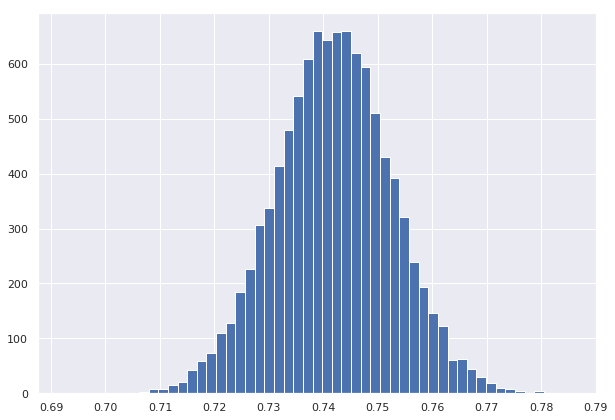

<Figure size 432x288 with 0 Axes>

In [47]:
plt.figure(figsize=(10,7))

plt.hist(bootstrapped_scores, bins=50)
plt.xticks(np.arange(0.69, 0.79, step=0.01))

# plt.title('')
plt.show()

plt.savefig("/home/marlan/Desktop/confidence_varq.pdf", bbox_inches='tight', pad_inches=0.1)

In [46]:
sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))


Confidence interval for the score: [0.721 - 0.763]


#### Logistic Regression

In [109]:
folds = 3
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1001)
algorithm = 'lr'
model = Pipeline(model_dict[algorithm]['pipe'])
param_list = [model_dict[algorithm]['params']][0]
gs = GridSearchCV(model, param_list, cv=skf.split(X_train, y_train), n_jobs=2, 
                  scoring='roc_auc', verbose=1, refit=True)

In [110]:
start = timer()
gs.fit(X_train, y_train)
timer(start)

Fitting 3 folds for each of 14 candidates, totalling 42 fits

 Time taken: 0 hours 0 minutes and 1.07 seconds.


[Parallel(n_jobs=2)]: Done  42 out of  42 | elapsed:    0.9s finished


In [111]:
lr = gs.best_estimator_

In [112]:
gs.best_score_

0.7146615271475478

In [124]:
pd.Series(y_pred).value_counts()

1    2228
0     220
dtype: int64

In [122]:
start= timer()
y_pred = lr.predict(X_test)
timer(start)


 Time taken: 0 hours 0 minutes and 0.0 seconds.


In [125]:
fbeta_score(y_test, y_pred, beta=1)

0.8360819590204899

In [87]:
fpr, tpr, _ = roc_curve(y_test, lr.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
roc_auc

0.7118483602581301

In [ ]:
lr.steps[2]

In [ ]:
importances = list(zip(X_train.columns.tolist(), lr.steps[2][1].coef_[0].tolist()))

In [ ]:
figsize(20,6)
# plt.title("Logistic Regression Coefficients", fontsize=16)
plt.barh(np.arange(len(importances)), [y for x, y in importances], color="g", align="center")
plt.xlabel("Coeficientes", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(range(len(importances)), [x for x, y in importances], rotation='horizontal', fontsize=16)
# plt.xticks(np.arange(-1.1,.7,.05))
plt.show()

#### SVM

In [58]:
folds = 3
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1001)
algorithm = 'svc'
model = Pipeline(model_dict[algorithm]['pipe'])
param_list = [model_dict[algorithm]['params']][0]
gs = GridSearchCV(model, param_list, cv=skf.split(X_train, y_train), n_jobs=2, 
                  scoring='roc_auc', verbose=1, refit=True)

In [59]:
X_test.shape

(2448, 9)

In [60]:
pd.Series(y_test).value_counts()

1    1774
0     674
dtype: int64

In [ ]:
gs.fit(X_train, y_train)

In [51]:
svc = gs.best_estimator_

In [53]:
gs.best_score_

0.6992159446523492

In [61]:
X_train.columns

Index(['SASA', 'SASA_PERCENTAGE', 'BFACTOR', 'SWITCHBILITY', 'AGGREGABILITY',
       'CONSERVATION', '3DID', 'PDB', 'VARIATION_ENERGY'],
      dtype='object')

In [62]:
y_pred = svc.predict(X_test)

In [72]:
recall_score(y_test, y_pred)

1.0

In [69]:
pd.Series(y_pred).value_counts()

1    2448
dtype: int64

In [66]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       674
          1       0.72      1.00      0.84      1774

avg / total       0.53      0.72      0.61      2448



/home/marlan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [54]:
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

In [55]:
roc_auc

0.6984939900106718

In [ ]:
fpr.shape

In [ ]:
figsize(7,7)

lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC Curve')
plt.legend(loc="lower right", prop={'size': 12})

plt.savefig("../documents/latex/figures/3/auc_varq.pdf", bbox_inches='tight', pad_inches=0.1)

## Algorithm Comparison

In [ ]:
algos = ["LR", "RF", "SVC"]
aucs = [0.71, 0.74, 0.70]

In [ ]:
plt.rcParams["font.family"] = "DejaVu Sans"

plt.figure(figsize=(10, 4))

barlist = plt.bar(algos, aucs, alpha=0.6)
barlist[0].set_color('mediumaquamarine')
barlist[1].set_color('forestgreen')
barlist[2].set_color('darkmagenta')

for i, rect in enumerate(barlist):
    height = rect.get_height()
    plt.gca().text(rect.get_x() + rect.get_width()/2., 1.05*height, aucs[i], ha='center', va='bottom', fontsize=18)


plt.xticks(fontsize=16)
plt.yticks(np.arange(0,1.1, 0.5), fontsize=18)

# plt.show()
# plt.legend(["AUC"], fontsize=16)

plt.savefig("varq_results.pdf", bbox_inches='tight', pad_inches=0.1)